In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(256, 256),
    batch_size=32,
)

Found 7196 files belonging to 2 classes.


In [3]:
class_names = dataset.class_names
print(class_names)

['Strawberry___Leaf_scorch', 'Strawberry___healthy']


In [4]:
len(dataset)

225

In [5]:
# 0,1,2,3...9 classes (10 classes)
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0].shape)

(32, 256, 256, 3)
[1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1]
(256, 256, 3)


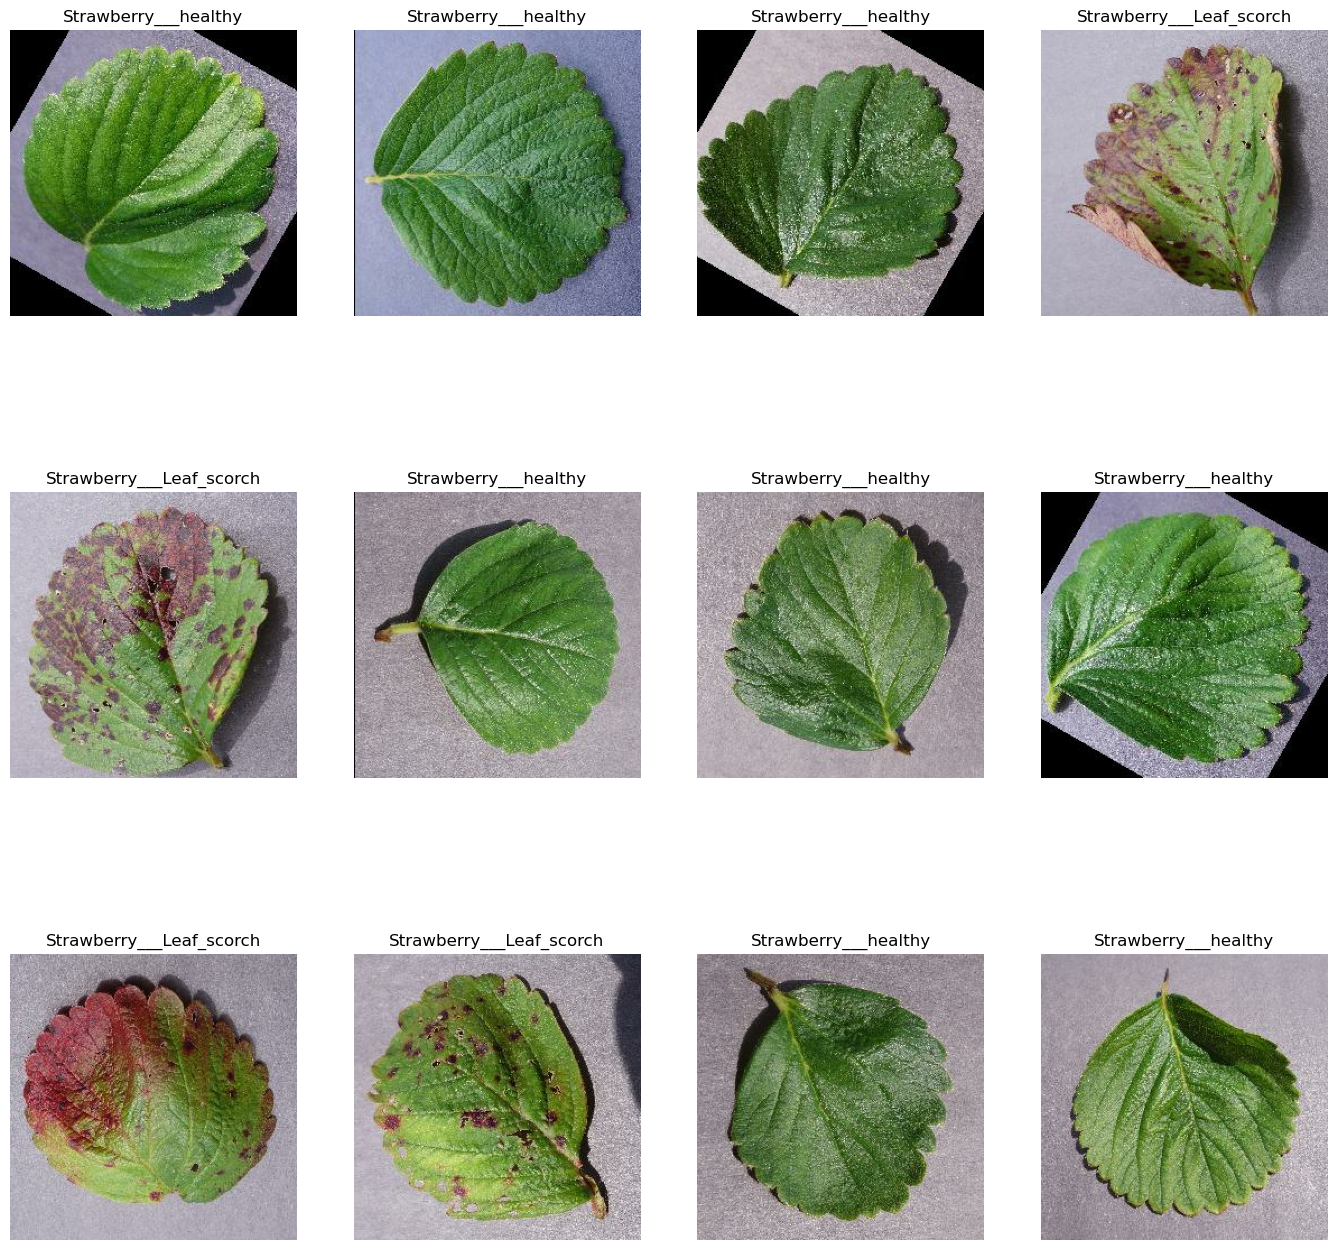

In [6]:
#visualize image
plt.figure(figsize=(17,17)) #to fix images size
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
#80% ==> training 
#20% ==> 10% validation, 10% test

In [8]:
def dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = dataset_partition(dataset)

In [10]:
print(len(train_ds),
len(val_ds),
len(test_ds))

180 22 23


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),
    tf.keras.layers.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
input_shape = (32, 256, 256, 3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])
model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [16]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [17]:
history = model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=50,
          batch_size=32,
          verbose=1)

Epoch 1/50
180/180 [==============================] - 30s 112ms/step - loss: 0.2526 - accuracy: 0.8829 - val_loss: 0.2283 - val_accuracy: 0.9247
Epoch 2/50
180/180 [==============================] - 16s 86ms/step - loss: 0.0203 - accuracy: 0.9925 - val_loss: 0.0165 - val_accuracy: 0.9943
Epoch 3/50
180/180 [==============================] - 14s 80ms/step - loss: 0.0101 - accuracy: 0.9964 - val_loss: 2.4091e-04 - val_accuracy: 1.0000
Epoch 4/50
180/180 [==============================] - 13s 75ms/step - loss: 0.0030 - accuracy: 0.9991 - val_loss: 0.0060 - val_accuracy: 0.9986
Epoch 5/50
180/180 [==============================] - 13s 74ms/step - loss: 2.7653e-04 - accuracy: 0.9998 - val_loss: 1.8762e-07 - val_accuracy: 1.0000
Epoch 6/50
180/180 [==============================] - 13s 73ms/step - loss: 2.7844e-06 - accuracy: 1.0000 - val_loss: 7.6875e-08 - val_accuracy: 1.0000
Epoch 7/50
180/180 [==============================] - 13s 73ms/step - loss: 4.3906e-07 - accuracy: 1.0000 - val_los

In [18]:
scores = model.evaluate(test_ds)

23/23 [==============================] - 3s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [19]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 180}

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
history.history['accuracy']

[0.8829047679901123,
 0.9925295114517212,
 0.9963516592979431,
 0.9991313219070435,
 0.9998262524604797,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

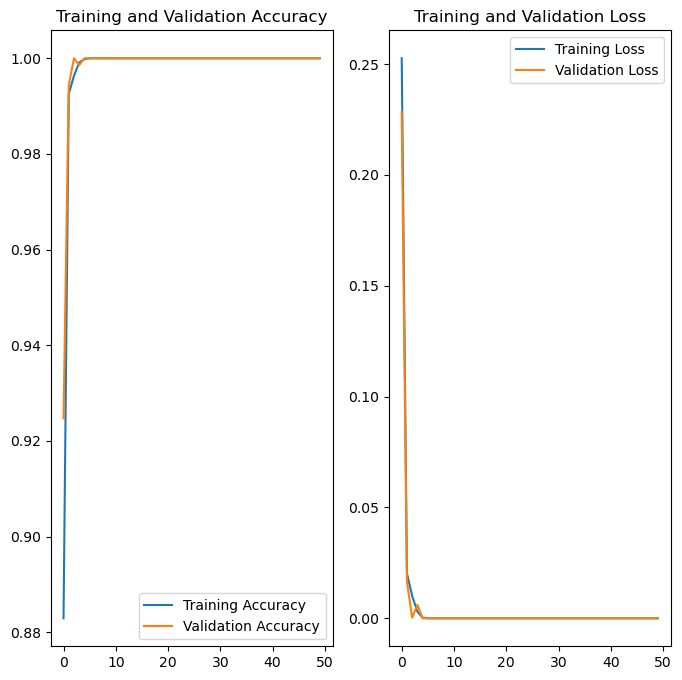

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual lable:  Strawberry___healthy
1/1 [==============================] - 0s 123ms/step
Predicted lable:  Strawberry___healthy


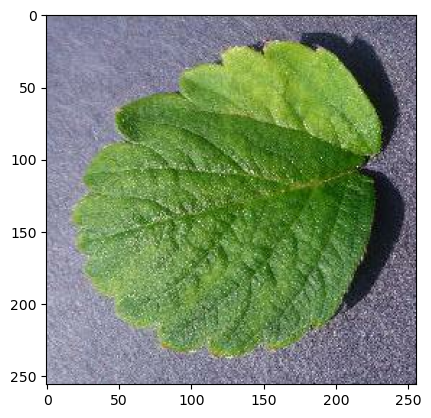

In [24]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype("uint8"))
    first_lable = label_batch[0].numpy()

    print("First image to predict")

    plt.imshow(first_image)
    print("Actual lable: ", class_names[first_lable])
    #print(class_names[first_lable])

    batch_prediction = model.predict(image_batch)
    print("Predicted lable: ", class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 13ms/step


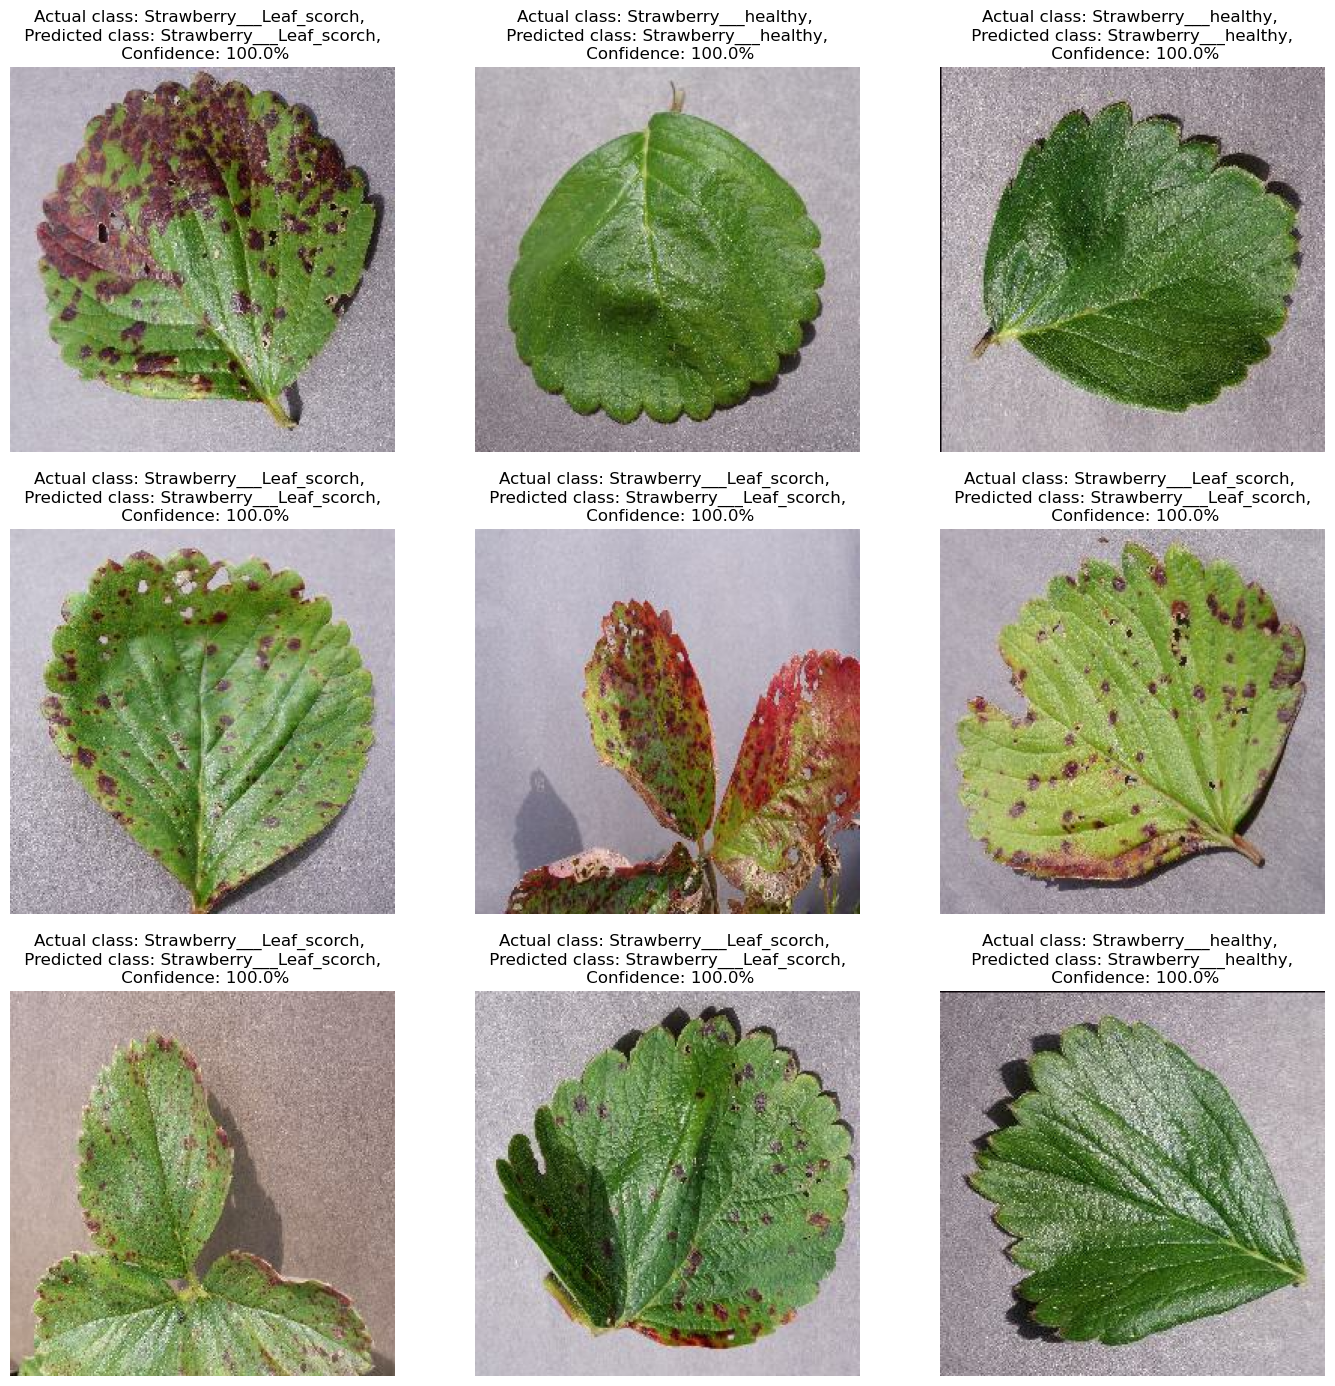

In [26]:
plt.figure(figsize=(17,17))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]


        plt.title(f"Actual class: {actual_class}, \n Predicted class: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

In [27]:
model_version = "Strawberry_Training_v1"
model.save(f"../Models/{model_version}")



INFO:tensorflow:Assets written to: ../Models/Strawberry_Training_v1\assets


INFO:tensorflow:Assets written to: ../Models/Strawberry_Training_v1\assets
